In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tkl
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
import os
import sys
sys.path.insert(0, '.')
from unet import *

In [2]:
DIR_ANNOTATIONS = './dataset/annotations/'
DIR_VIDEOS = './dataset/videos/'
SHAPE = (512, 512, 3)
scenes_list = ['bookstore', 'coupa', 'deathCircle', 'gates', 'hyang', 'little', 'nexus', 'quad']


In [3]:
annot = pd.read_csv(f'{DIR_ANNOTATIONS}{scenes_list[0]}/video0/annotations.txt', sep=' ', header=None)

In [4]:
annot.columns = ['track_id', 'xmin', 'ymin', 'xmax', 'ymax', 'frame', 'lost', 'occluded', 'generated', 'label']
annot

,track_id,xmin,ymin,xmax,ymax,frame,lost,occluded,generated,label
0,0,213,1038,241,1072,10000,1,0,0,Biker
1,0,211,1038,239,1072,10001,1,0,1,Biker
2,0,211,1038,239,1072,10002,1,0,1,Biker
3,0,211,1038,239,1072,10003,1,0,1,Biker
4,0,211,1038,239,1072,10004,1,0,1,Biker
...,...,...,...,...,...,...,...,...,...,...
361124,236,0,995,41,1072,8527,1,0,1,Biker
361125,236,0,995,41,1072,8528,1,0,1,Biker
361126,236,0,995,41,1072,8529,1,0,1,Biker
361127,236,0,995,41,1072,8530,1,0,1,Biker


In [5]:
movie = cv2.VideoCapture(f'{DIR_VIDEOS}{scenes_list[0]}/video0/video.mov')
movie.isOpened()

True

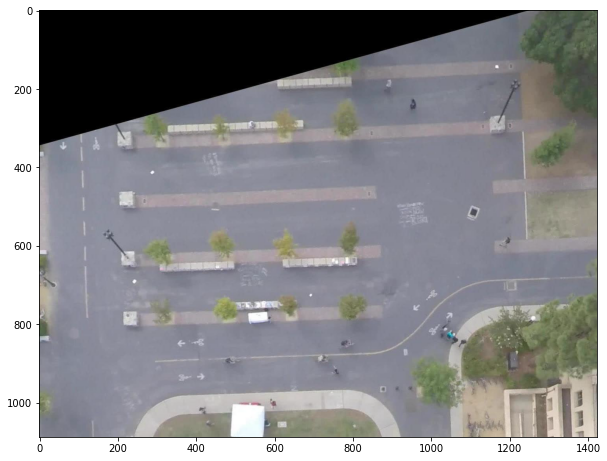

In [7]:
plt.rcParams['figure.figsize'] = (10,10)
ret, frame = movie.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

In [8]:
annot[annot.frame==0]

,track_id,xmin,ymin,xmax,ymax,frame,lost,occluded,generated,label
30980,15,1382,553,1420,602,0,1,0,0,Pedestrian
38640,20,735,897,779,940,0,0,0,0,Pedestrian
46300,25,583,1001,613,1038,0,1,0,0,Pedestrian
49896,28,878,160,917,206,0,0,0,0,Pedestrian
53992,31,399,997,419,1029,0,0,0,0,Pedestrian
86824,57,413,1033,443,1067,0,0,0,0,Pedestrian
98080,65,579,983,619,1020,0,0,0,0,Pedestrian
202160,130,925,213,979,260,0,0,0,0,Pedestrian
209416,138,456,877,518,913,0,0,0,0,Biker
209948,139,692,861,749,911,0,0,0,0,Biker


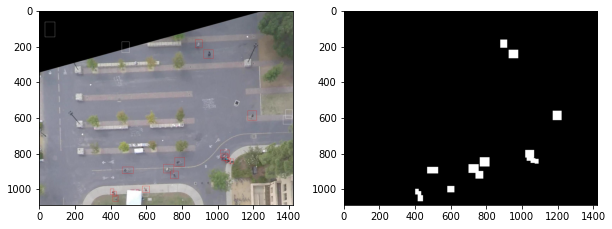

In [9]:
annot_frame_3 = annot[annot.frame==3]
# plt.rcParams['figure.figsize'] = (15, 15)
mask = np.zeros(frame.shape, dtype=np.uint8)
for i in range(len(annot_frame_3)):
    if annot_frame_3.lost.iloc[i] == 1:
        color = (255,255,255)
    else:
        color = (255,0,0)
        mask[annot_frame_3.ymin.iloc[i]:annot_frame_3.ymax.iloc[i], annot_frame_3.xmin.iloc[i]:annot_frame_3.xmax.iloc[i]] = (255,255,255)
        
    frame = cv2.rectangle(frame, (annot_frame_3.xmin.iloc[i], annot_frame_3.ymin.iloc[i]), 
                           (annot_frame_3.xmax.iloc[i], annot_frame_3.ymax.iloc[i]), color, 1)
plt.subplot(121)
plt.imshow(frame)
plt.subplot(122)
plt.imshow(mask)

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tk.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [14]:
annot = {}
for scene in scenes_list:
    ann = []
    for i in range(4):
        a = pd.read_csv(f'{DIR_ANNOTATIONS}{scene}/video{i}/annotations.txt', sep=' ', header=None)
        a.columns = ['track_id', 'xmin', 'ymin', 'xmax', 'ymax', 'frame', 'lost', 'occluded', 'generated', 'label']
        ann.append(a)
    annot[scene] = ann

In [12]:
def load_samples(scenes, annot, video_num, total_samples):
    X = []  
    Y = []  
    data_size = total_samples // len(scenes)
    num_total = 0
    for scene in scenes:
        movie = cv2.VideoCapture(f'{DIR_VIDEOS}{scene}/video{video_num}/video.mov')
        frames_num = int(movie.get(cv2.CAP_PROP_FRAME_COUNT))
        ann = annot[scene][video_num]
        frame_num = 0
        skip_frames = int(frames_num / data_size)
        if skip_frames > 30:
            skip_frames = 30 
        if skip_frames < 1:
            skip_frames = 1 
        print(f'{scene}, frames={frames_num}, skip_frames={skip_frames}')
        
        num_scene = 0
        movie_is_opened, frame = movie.read()
        while movie_is_opened:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            annot_frame = ann[ann.frame==frame_num]
            mask = np.zeros((frame.shape[0], frame.shape[1], 1), dtype=np.uint8)
            for i in range(len(annot_frame)):
                if annot_frame.lost.iloc[i] == 0 and annot_frame.occluded.iloc[i] == 0:
                    mask[annot_frame.ymin.iloc[i]:annot_frame.ymax.iloc[i], annot_frame.xmin.iloc[i]:annot_frame.xmax.iloc[i], 0] = 255

            X.append(frame)
            Y.append(mask)
            num_total += 1
            if num_total % 100 == 0:
                print('.', end='') 

            num_scene += 1
            if num_scene == data_size:
                break

            for _ in range(skip_frames):
                movie_is_opened, frame = movie.read()
                frame_num += 1
    return X, Y

In [15]:
imgs, masks = load_samples(scenes_list, annot, video_num=0, total_samples=3000)
print(len(imgs), len(masks))

bookstore, frames=13335, skip_frames=30
...coupa, frames=11966, skip_frames=30
....deathCircle, frames=12721, skip_frames=30
....gates, frames=9006, skip_frames=24
....hyang, frames=11368, skip_frames=30
...little, frames=1518, skip_frames=4
....nexus, frames=12681, skip_frames=30
....quad, frames=509, skip_frames=1
....3000 3000


In [16]:
num_total = len(imgs)
print(num_total)
num_train = int(num_total * 0.9)
num_val = int(num_total * 0.05)
num_test = num_total - num_train - num_val
print(f'num_train: {num_train}, num_val: {num_val}, num_test: {num_test}')

3000
num_train: 2700, num_val: 150, num_test: 150


In [17]:
idx_total = list(range(num_total))
random.shuffle(idx_total)
idx_val = idx_total[:num_val]
idx_test = idx_total[num_val:num_val+num_test]
idx_train = idx_total[num_val+num_test:]

In [19]:
imgs_val = [imgs[i] for i in idx_val]
masks_val = [masks[i] for i in idx_val]
imgs_test = [imgs[i] for i in idx_test]
masks_test = [masks[i] for i in idx_test]
imgs_train = [imgs[i] for i in idx_train]
masks_train = [masks[i] for i in idx_train]
print(len(imgs_val), len(imgs_test), len(imgs_train))

150 150 2700


In [24]:
def get_pair_rnd(imgs, masks, idx, shape):
    """get random image and corresponding mask from dataset, with augmentation"""
    w = imgs[idx].shape[1]
    h = imgs[idx].shape[0]
    for i in range(10):  # tries to get crop with objects
        x = random.randint(0, w-shape[1])
        y = random.randint(0, h-shape[0])
        img = imgs[idx][y:y+shape[0], x:x+shape[1], :]
        mask = masks[idx][y:y+shape[0], x:x+shape[1], :]
        if np.max(mask) > 0:
            break
    if random.randint(0,3) > 0:
        rotate_code = random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE])
        img = cv2.rotate(img, rotate_code)
        mask = np.expand_dims(cv2.rotate(mask, rotate_code), axis=-1)
        
    if random.randint(0,1) > 0:
        flip_code = random.randint(-1, 1)
        img = cv2.flip(img, flip_code)
        mask = np.expand_dims(cv2.flip(mask, flip_code), axis=-1)
    return img, mask

In [21]:
def get_batch(imgs, masks, batch_size, shape):
    X_batch = np.zeros((batch_size, shape[1], shape[0], shape[2]))
    Y_batch = np.zeros((batch_size, shape[1], shape[0], masks[0].shape[-1]))
    for i in range(batch_size):
        idx = random.randint(0, len(imgs)-1)
        X_batch[i], Y_batch[i] = get_pair_rnd(imgs, masks, idx, shape)

    return X_batch / 255, Y_batch / 255

In [22]:
def data_generator(imgs, masks, batch_size, shape):
    while True:
        X_batch, Y_batch = get_batch(imgs, masks, batch_size, shape)
        yield X_batch, Y_batch

In [25]:
data_val = get_batch(imgs_val, masks_val, num_val, SHAPE)
print(data_val[0].shape, data_val[1].shape)
data_test = get_batch(imgs_test, masks_test, num_test, SHAPE)
print(data_test[0].shape, data_test[1].shape)

(150, 512, 512, 3) (150, 512, 512, 1)
(150, 512, 512, 3) (150, 512, 512, 1)


In [26]:
train_gen = data_generator(imgs_train, masks_train, batch_size=16, shape=SHAPE)

let's use Unet-like neural network:

In [27]:
unet3bn = Unet(3, SHAPE, filters_out=1, final_activation='sigmoid', batch_normalization=True)
unet3bn.summary()

Model: "U-net_3cas24fil1out"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 24) 672         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 24) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 24) 5208        batch_normalization[0][0]        
________________________________________________________________________________

In [28]:
unet3bn.compile(optimizer=tk.optimizers.Adam(), loss=bce_dice_loss, metrics=[dice_coef])
cb_checkpoint = tk.callbacks.ModelCheckpoint(filepath='./checkpoints/unet3bn_e{epoch:03d}-val_bce{val_loss:.4f}.hdf5',
                                             verbose=1,
                                             save_best_only=True)

cb_reducelr = tk.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, verbose=1, min_lr=1e-7)
cb_earlystop = tk.callbacks.EarlyStopping(patience=30, verbose=1)
callbacks = [cb_checkpoint, cb_reducelr, cb_earlystop]
h_unet3bn = unet3bn.fit(train_gen, epochs=200, verbose=2, steps_per_epoch=100, validation_data=data_val, callbacks=callbacks)

Epoch 1/200

Epoch 00001: val_loss improved from inf to 1.09238, saving model to ./checkpoints\unet3bn_e001-val_bce1.0924.hdf5
100/100 - 48s - loss: 0.9113 - dice_coef: 0.2637 - val_loss: 1.0924 - val_dice_coef: 0.0000e+00
Epoch 2/200

Epoch 00002: val_loss did not improve from 1.09238
100/100 - 44s - loss: 0.7811 - dice_coef: 0.3698 - val_loss: 1.1613 - val_dice_coef: 0.0000e+00
Epoch 3/200

Epoch 00003: val_loss did not improve from 1.09238
100/100 - 45s - loss: 0.7397 - dice_coef: 0.3999 - val_loss: 1.1843 - val_dice_coef: 0.0000e+00
Epoch 4/200

Epoch 00004: val_loss did not improve from 1.09238
100/100 - 45s - loss: 0.6928 - dice_coef: 0.4433 - val_loss: 1.1702 - val_dice_coef: 0.0000e+00
Epoch 5/200

Epoch 00005: val_loss did not improve from 1.09238
100/100 - 45s - loss: 0.6721 - dice_coef: 0.4607 - val_loss: 1.1823 - val_dice_coef: 0.0000e+00
Epoch 6/200

Epoch 00006: val_loss improved from 1.09238 to 0.79891, saving model to ./checkpoints\unet3bn_e006-val_bce0.7989.hdf5
100/10

In [30]:
def show_graphs(h, title):
    figsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (8,5)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.grid(which='both')
    plt.legend(['loss', 'val_loss'])
    plt.title(title)
    plt.rcParams["figure.figsize"] = figsize

5/5 [==============================] - 1s 190ms/step - loss: 0.3983 - dice_coef: 0.6748


[0.3983212411403656, 0.6747837662696838]

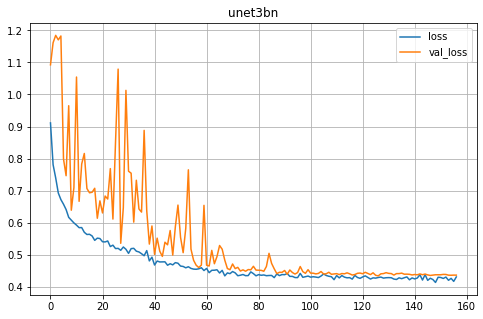

In [31]:
#./checkpoints\unet3bn_e127-val_bce0.4344.hdf5
show_graphs(h_unet3bn, 'unet3bn')
unet3bn.evaluate(x=data_test[0], y=data_test[1])

Text(0.5, 1.0, 'predict')

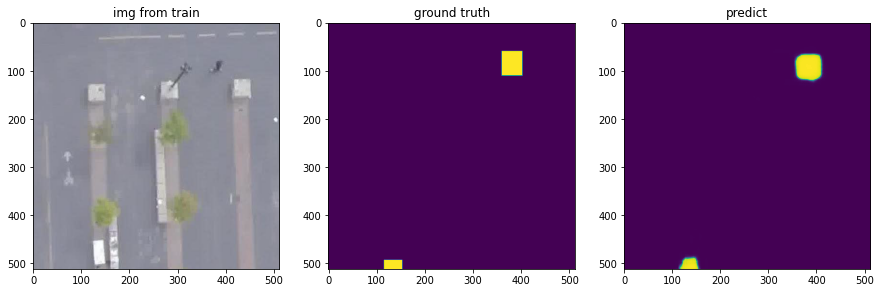

In [36]:
plt.rcParams['figure.figsize'] = (15, 15)
data_train = next(train_gen)
i = 5
img_train = np.round(data_train[0][i] * 255).astype(np.uint8)
plt.subplot(131)
plt.imshow(img_train)
plt.title('img from train')
mask_train = np.round(data_train[1][i] * 255).astype(np.uint8)
plt.subplot(132)
plt.imshow(mask_train)
plt.title('ground truth')
mask_pred = np.round(unet3bn.predict(data_train[0][i:i+1])[0] * 255).astype(np.uint8)
plt.subplot(133)
plt.imshow(mask_pred)
plt.title('predict')

Text(0.5, 1.0, 'predict')

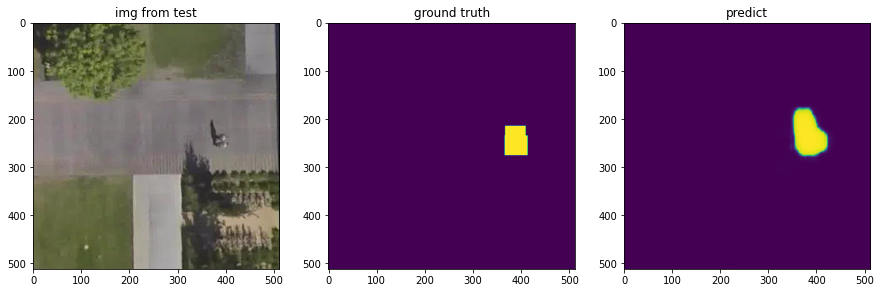

In [38]:
i = 30
img_test = np.round(data_test[0][i] * 255).astype(np.uint8)
plt.subplot(131)
plt.imshow(img_test)
plt.title('img from test')
mask_test = np.round(data_test[1][i] * 255).astype(np.uint8)
plt.subplot(132)
plt.imshow(mask_test)
plt.title('ground truth')
mask_pred = np.round(unet3bn.predict(data_test[0][i:i+1])[0] * 255).astype(np.uint8)
plt.subplot(133)
plt.imshow(mask_pred)
plt.title('predict')

trying to predict by resized source image

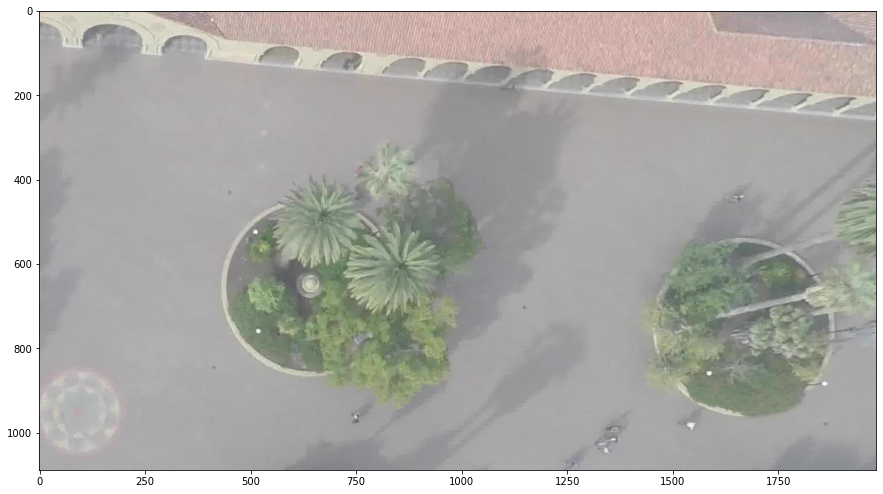

In [39]:
plt.imshow(imgs_val[0])

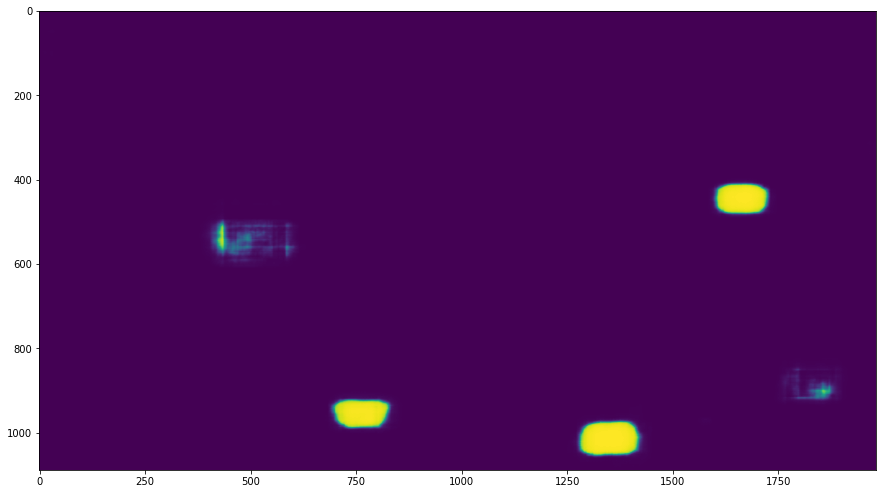

In [44]:
pred = unet3bn.predict(np.expand_dims(cv2.resize(imgs_val[0], (512,512)) / 255, axis=0))[0]
plt.imshow(cv2.resize(pred, (imgs_val[0].shape[1], imgs_val[0].shape[0])))

results are not so good. let's try to predict with big source image cutted into many tiles 512x512.

In [45]:
def get_mask(img, model, shape):
    """cutting source image by shape-sized tiles and combining them into batch, then un-tiling resulting batch back into one big image"""
    batch = []
    rounded_x = np.ceil(img.shape[1]/shape[1]).astype(int) * shape[1]
    rounded_y = np.ceil(img.shape[0]/shape[0]).astype(int) * shape[0]
    canvas = np.zeros((rounded_y, rounded_x, 3))
    canvas[:img.shape[0], :img.shape[1], :] = img / 255
    
    for i in range(0, img.shape[0], shape[0]):
        for j in range(0, img.shape[1],  shape[1]):
            y, x = i, j
            if img.shape[0] - y < shape[0]:
                y = img.shape[0] - shape[0]
            if img.shape[1] - x < shape[1]:
                x = img.shape[1] - shape[1]
            batch.append(canvas[y:y+shape[0], x:x+shape[1],:])
    batch = np.array(batch)
    pred_batch = model.predict(batch) * 255
    pred_img = np.zeros((rounded_y, rounded_x, 3), dtype=np.uint8)
    k = 0
    for i in range(0, img.shape[0], shape[0]):
        for j in range(0, img.shape[1], shape[1]):
            y, x = i, j
            if img.shape[0] - y < shape[0]:
                y = img.shape[0] - shape[0]
            if img.shape[1] - x < shape[1]:
                x = img.shape[1] - shape[1]

            pred_img[y:y+shape[0], x:x+shape[1],:] = np.round(pred_batch[k,:,:,:])
            k += 1
    pred_img = pred_img[:img.shape[0], :img.shape[1], :]
    return pred_img

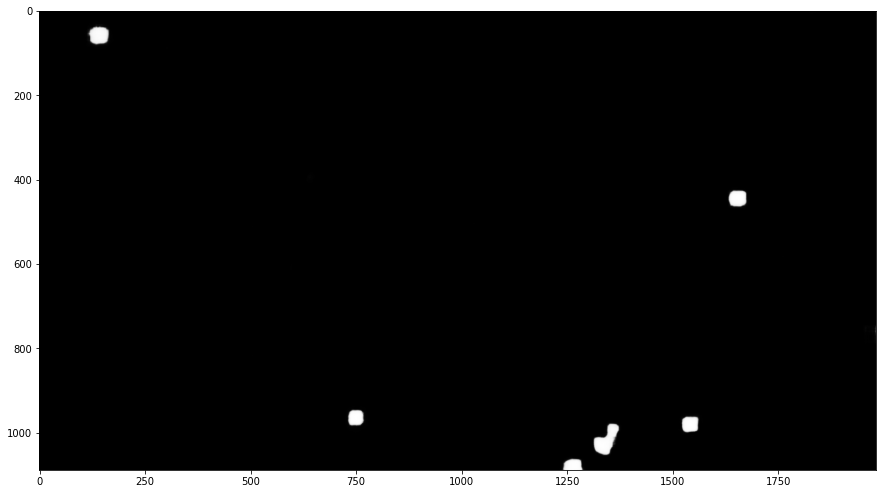

In [46]:
pred = get_mask(imgs_val[0], unet3bn, SHAPE)
plt.imshow(pred)

looks much better. compare with ground truth:

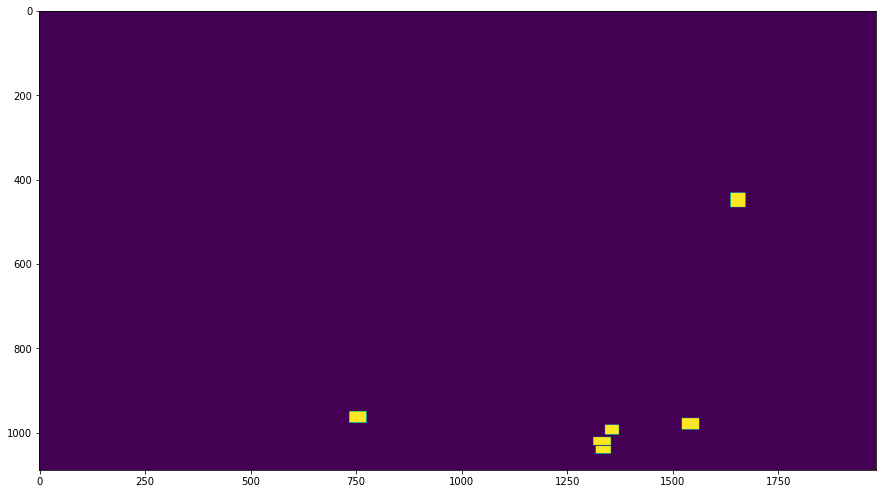

In [47]:
plt.imshow(masks_val[0])